In [ ]:
## TASK 2 sentiment analysis with GloVe embeddings
# Tanay Tripathi


In [47]:
#importing libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
import matplotlib.pyplot as plt





In [10]:
data = pd.read_csv('raw_data.csv')

In [11]:
from sklearn.model_selection import train_test_split
def new(covid,sentiment):
    if ((covid==1) & (sentiment==0)):
        score = 0
    elif ((covid==1) & (sentiment==1)):
        score = 1
    elif ((covid == 0) & (sentiment==0)):
        score = 2
    elif ((covid == 0) & (sentiment==1)):
        score = 3
    return score

c = data['Covid'].tolist()
s = data['Sentiment'].tolist()
score = []
for i  in range(0,4072):
    score.append(new(c[i],s[i]))
data['label'] = score

data = data[['Headline','label']]

train , valid = train_test_split(data , test_size = 0.2 , random_state = 42)

In [12]:

#train_test split
x_tr, y_tr = train['Headline'].values, train['label'].values
x_val, y_val = valid['Headline'].values, valid['label'].values

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#Tokenize the sentences
tokenizer = Tokenizer()

#preparing vocabulary
tokenizer.fit_on_texts(list(x_tr))

#converting text into integer sequences
x_tr_seq  = tokenizer.texts_to_sequences(x_tr) 
x_val_seq = tokenizer.texts_to_sequences(x_val)

#padding to prepare sequences of same length
x_tr_seq  = pad_sequences(x_tr_seq, maxlen=100)
x_val_seq = pad_sequences(x_val_seq, maxlen=100)

In [20]:
size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

6316


In [14]:
!wget -P /root/input/ -c "http://nlp.stanford.edu/data/glove.6B.zip"
!unzip 'glove.6B.zip'

--2021-01-27 12:25:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-01-27 12:25:39--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-01-27 12:25:39--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/root/input/glove.6B.z

In [15]:
!unzip '/root/input/glove.6B.zip'

Archive:  /root/input/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [17]:
embeddings_index = dict()
f = open('glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [21]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [28]:
model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=100,trainable=False)) 

#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(4,activation='softmax')) 

#Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=["acc"]) 

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

#Print summary of model
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          1894800   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 128)          219648    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 260       
Total params: 2,122,964
Trainable params: 228,164
Non-trainable params: 1,894,800
_________________________________________________________________
None


In [29]:
history = model.fit(np.array(x_tr_seq),np.array(y_tr),batch_size=128,epochs=10,validation_data=(np.array(x_val_seq),np.array(y_val)),verbose=1,callbacks=[es,mc])

Epoch 1/10
26/26 [==============================] - 11s 366ms/step - loss: 1.1554 - acc: 0.4834 - val_loss: 0.8652 - val_acc: 0.6233

Epoch 00001: val_acc improved from -inf to 0.62331, saving model to best_model.h5
Epoch 2/10
26/26 [==============================] - 9s 359ms/step - loss: 0.8201 - acc: 0.6663 - val_loss: 0.7294 - val_acc: 0.6908

Epoch 00002: val_acc improved from 0.62331 to 0.69080, saving model to best_model.h5
Epoch 3/10
26/26 [==============================] - 9s 361ms/step - loss: 0.6762 - acc: 0.7312 - val_loss: 0.6837 - val_acc: 0.7129

Epoch 00003: val_acc improved from 0.69080 to 0.71288, saving model to best_model.h5
Epoch 4/10
26/26 [==============================] - 9s 355ms/step - loss: 0.6048 - acc: 0.7558 - val_loss: 0.6597 - val_acc: 0.7288

Epoch 00004: val_acc improved from 0.71288 to 0.72883, saving model to best_model.h5
Epoch 5/10
26/26 [==============================] - 9s 353ms/step - loss: 0.5348 - acc: 0.7841 - val_loss: 0.6482 - val_acc: 0.732

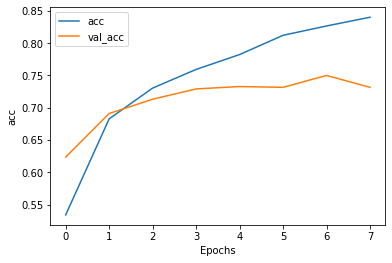

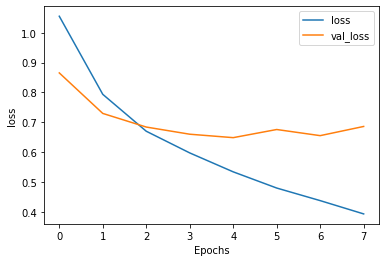

In [49]:
# Plotting accuracy vs epochs and loss vs epochs graph 
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [30]:
from keras.models import load_model
model = load_model('best_model.h5')

#evaluation 
_,val_acc = model.evaluate(x_val_seq,y_val, batch_size=128)
print(val_acc)

7/7 [==============================] - 1s 107ms/step - loss: 0.6549 - acc: 0.7497
0.7496932744979858


In [37]:
# Function to predict 
def pred(text):
  x_test = []
  x_test.append(text)
  x_test_seq_1 = tokenizer.texts_to_sequences(x_test)
  x_test_seq_2 = pad_sequences(x_test_seq_1, maxlen=100)
  return x_test_seq_2

In [45]:
# Change the output in text for prediction
text = "Smriti Irani celebrates daughters Zoish, Shanelle with throwback pic."
x_test_1 = pred(text)
x_test_1 = np.array(x_test_1)
result = model.predict(x_test_1)
print(np.argmax(result))

3
